In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
file_path = '/data/opinion_spam/real/reviewsNew.txt'
datas = []
MIN_FD = 100
raw_file = open(file_path)
for line in raw_file:    
    try:
        line = line.decode('gbk')
    except:
        continue
    #print 'gbk', line
    line = line.encode('utf-8')
    #print 'utf8', line
    item = line.split('\t')
    if len(item) == 8:
        hfd = float(item[3])
        fd = float(item[4])
        ratings = float(item[5])
        if fd > MIN_FD:
            hfdfd = round(hfd/fd, 2)
            #whole_filted_body += item[7]
            item.append(hfdfd)
            datas.append(item)
raw_file.close()
print datas[0]

['A1004AX2J2HXGL', 'B00003CWPL', 'December 2, 2003', '111', '125', '5.0', '"But what the hell do they know, I said?"', ' If you\'re reading this, then you\'ve seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I\'ve seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I\'ve long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD is the cinematic exp

In [3]:
#set column names
column_names = ['rid', 'pid', 'date', 'hfd', 'fd', 'rating', 'title', 'body', 'hfdfd']
df = pd.DataFrame(datas)
df.columns = column_names
df.head()

,rid,pid,date,hfd,fd,rating,title,body,hfdfd
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5.0,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5.0,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4.0,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1.0,UGGHHH,Craptacular and boring. The cinematography an...,0.05
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5.0,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00


In [4]:
#transfer the type of column
df[['hfd', 'fd','rating']] = df[['hfd', 'fd', 'rating']].astype(float)

In [5]:
df.describe()

,hfd,fd,rating,hfdfd
count,19037.000000,19037.000000,19037.000000,19037.000000
mean,123.116983,175.209697,3.517519,0.686689
std,136.342928,148.198851,1.690601,0.332028
min,0.000000,101.000000,1.000000,0.000000
25%,56.000000,114.000000,2.000000,0.390000
50%,106.000000,138.000000,4.000000,0.860000
75%,147.000000,186.000000,5.000000,0.970000
max,8026.000000,8262.000000,5.000000,1.000000


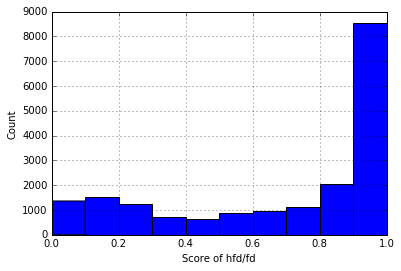

In [6]:
#hfdfd distribution
df.hfdfd.hist()
plt.title='The Distribute of hfd/fd'
plt.xlabel('Score of hfd/fd')
plt.ylabel('Count')

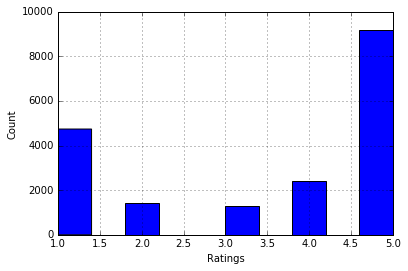

In [7]:
#rating distribution
df.rating.hist()
plt.xlabel('Ratings')
plt.ylabel("Count")

In [8]:
#count how many products in the dataset  ==》9809 products
df.groupby('pid').count()

,rid,date,hfd,fd,rating,title,body,hfdfd
pid,,,,,,,,
0007131844,1,1,1,1,1,1,1,1
0007142951,1,1,1,1,1,1,1,1
0007162200,1,1,1,1,1,1,1,1
0007164653,1,1,1,1,1,1,1,1
0020425651,1,1,1,1,1,1,1,1
0020453701,1,1,1,1,1,1,1,1
002073610X,2,2,2,2,2,2,2,2
002860055X,1,1,1,1,1,1,1,1
0028610105,1,1,1,1,1,1,1,1


In [9]:
df.shape

(19037, 9)

In [10]:
df['title_len'] = df['title'].apply(len)
df['body_len'] = df['body'].apply(len)

In [11]:
df.head()

,rid,pid,date,hfd,fd,rating,title,body,hfdfd,title_len,body_len
0,A1004AX2J2HXGL,B00003CWPL,"December 2, 2003",111,125,5,"""But what the hell do they know, I said?""","If you're reading this, then you've seen this...",0.89,41,2642
1,A103PHKSEPT10R,0939484463,"July 5, 2000",69,116,5,"Credible, Interesting, & Devasting",I've read Prof Butz's book twice and an still...,0.59,34,313
2,A103U0Q3IKSXHE,0875845851,"January 29, 2000",111,115,4,Identifying the horns of the dilemma.,"Prior to reading this book, I chalked up the ...",0.97,37,1495
3,A105YVLAZNYQUU,B000634DCW,"June 21, 2005",6,112,1,UGGHHH,Craptacular and boring. The cinematography an...,0.05,6,1045
4,A1075MZNVRMSEO,1563249367,"April 2, 2002",190,190,5,A historical portrait & revelation- un chin de...,This book is a fascinating journey through th...,1.00,59,2180


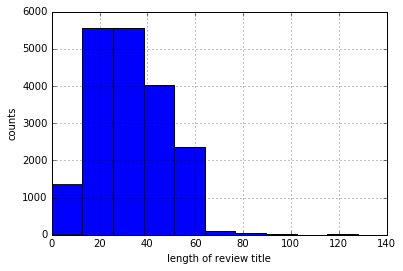

In [12]:
df['title_len'].hist()
plt.xlabel('length of review title')
plt.ylabel('counts')

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


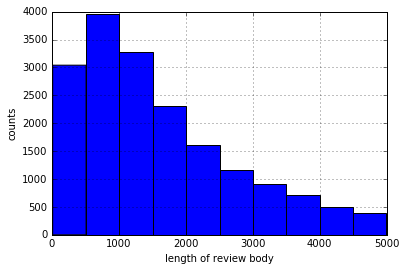

In [13]:
df[df['body_len'] > 10][df['body_len'] < 5000]['body_len'].hist()
plt.xlim(0, 5000)
plt.xlabel("length of review body")
plt.ylabel("counts")

In [14]:
df[['title_len', 'body_len']].describe()

,title_len,body_len
count,19037.000000,19037.000000
mean,32.753060,1884.017807
std,14.984916,1674.183010
min,0.000000,9.000000
25%,21.000000,715.000000
50%,31.000000,1384.000000
75%,44.000000,2534.000000
max,128.000000,26425.000000


In [15]:
#TFIDF feature without lsa

import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)

tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'mse2:', mse2
print 'rmse2:', np.sqrt(mse2)
print 'rmse2 mean:', np.mean(np.sqrt(mse2))


the tfidf matrix size :  (19037, 10000)
<class 'scipy.sparse.csr.csr_matrix'>
mse2: [ 0.13520997  0.13642166  0.1338893   0.14038979  0.1302411   0.12811904
  0.12321814  0.14582795  0.20725045  0.14061438]
rmse2: [ 0.36770909  0.36935303  0.36590887  0.37468625  0.36088931  0.3579372
  0.35102441  0.38187426  0.45524768  0.37498584]
rmse2 mean: 0.375961593604


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [16]:
#TFIDF feature without lsa
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import evaluation_self as es
max_features_count = 10000
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features_count,
                                 min_df=2, stop_words='english', tokenizer = es.tokenize_and_stem)
tfidf_matrix = vectorizer.fit_transform(df.body)
print "the tfidf matrix size : ",tfidf_matrix.shape
print type(tfidf_matrix)

lsaornot = True
lsanum = 1000

if lsaornot:
    print "Performing dimensionality reduction using LSA"
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(lsanum)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    tfidf_matrix = lsa.fit_transform(tfidf_matrix)

    print "done in ", (time() - t0)
    explained_variance = svd.explained_variance_ratio_.sum()
    print "Explained variance of the SVD step:", int(explained_variance * 100)


from sklearn.linear_model import LinearRegression

lr = LinearRegression()

from sklearn.cross_validation import cross_val_score

scores2 = cross_val_score(lr, tfidf_matrix, df.hfdfd, cv=10, scoring="mean_squared_error")

mse2 = abs(scores2)
print 'mse2:', mse2
print 'rmse2:', np.sqrt(mse2)
print 'rmse2 mean:', np.mean(np.sqrt(mse2))


the tfidf matrix size :  (19037, 10000)
<class 'scipy.sparse.csr.csr_matrix'>
Performing dimensionality reduction using LSA
done in  72.0235910416
Explained variance of the SVD step: 46
mse2: [ 0.04759054  0.04898991  0.05031199  0.05253637  0.05303875  0.05234223
  0.0560442   0.06633931  0.12659595  0.06366844]
rmse2: [ 0.21815257  0.22133665  0.22430335  0.22920815  0.23030142  0.22878425
  0.23673655  0.25756419  0.35580325  0.25232606]
rmse2 mean: 0.245451643282


In [17]:
#STD features

import nltk
import re

def seg_sentence(text):
    sentences = nltk.sent_tokenize(text)
    return [s.strip() for s in sentences if(len(s)) > 0]

def marks_num(text, pattern):
    return len(re.findall(pattern, text))

std_exc = 0
def std(text): # std in Yang@acl-2015
#    print '==============================='
    ary = [0, 0, 0, 0, 0]
    try:
        tokens = es.tokenize_and_stem(text)
        token_num = len(tokens)
    #    print 'token size:', token_num
        sentences = seg_sentence(text)
        sen_num = len(sentences)
    #    print 'sentence size:', sen_num
        avg_sentence_len = np.mean([len(x) for x in sentences])
    #    print 'avg sentence length:', avg_sentence_len
        exc_num = marks_num(text, r'[!！]')
    #    print 'exclamation marks count:', exc_num
        que_num = marks_num(text, r'[？?]')
    #    print 'question percentage:', float(que_num) / sen_num
        ary = [token_num, sen_num, avg_sentence_len, exc_num, que_num]
#         print ary
    except:
#         print text
        std_exc += 1
    finally:
        return ary
    
for loc in range(1, 10):
    std(df.body.head(10)[loc])

In [18]:
#Test std regression


std_x = np.array(df.body)
print type(std_x)
std_x = np.array(map(std, std_x))
print "std exception: ", std_exc

print type(std_x)
print std_x.shape

from sklearn.linear_model import LinearRegression
std_lr = LinearRegression()

std_scores = cross_val_score(std_lr, std_x, df.hfdfd, cv=10, scoring='mean_squared_error')

std_mse = abs(std_scores)
print 'std mse:', std_mse
print 'std rmse:', np.sqrt(std_mse)
print 'std rmse mean:', np.mean(np.sqrt(std_mse))

<type 'numpy.ndarray'>
std exception:  0
<type 'numpy.ndarray'>
(19037, 5)
std mse: [ 0.06980408  0.08158675  0.08349112  0.08241059  0.08448761  0.08758538
  0.09803277  0.11028616  0.20869914  0.10422509]
std rmse: [ 0.26420462  0.28563394  0.2889483   0.28707246  0.29066752  0.29594828
  0.31310186  0.33209359  0.45683601  0.3228391 ]
std rmse mean: 0.313734567262


In [29]:
#Syntactic features of Kim
import nltk
text = df.body.head(1)[0]
print text
#print nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])

def pos_count(text):
    poses = nltk.pos_tag([word  for sentence in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentence)])
    pos_dict = {}
    for (word, pos) in poses:
        if pos in pos_dict:
            pos_dict[pos] = pos_dict[pos] + 1
        else:
            pos_dict[pos] = 1
    return pos_dict

pos_dict = pos_count(text)#per sentence per second!!!!
for pos in pos_dict:
    print pos, " => ", pos_dict[pos]
print 'aa'
syn_exc = 0

def fetch_count_from_pos_dict(pos_list, pos_dict):
    _pos_count = 0
    for pos in pos_list:
        if pos in pos_dict:
            _pos_count += pos_dict[pos]
    return _pos_count

def syntactic_feature(text): #syn feature function
    ary = [0, 0, 0, 0]
    try:
        pos_dict = pos_count(text)
        nn_count = fetch_count_from_pos_dict(['NN', 'NNS', 'NNP', 'NNPS'], pos_dict)#noun
        jj_count = fetch_count_from_pos_dict(['JJ', 'JJR', 'JJS'], pos_dict)#adj
        vb_count = fetch_count_from_pos_dict(['VB', 'VBD', 'VBG', 'VBN', 'VNP', 'VBZ'], pos_dict)#vb
        rb_count = fetch_count_from_pos_dict(['RB', 'RBR', 'RBS'], pos_dict)#adv
        ary = [nn_count, jj_count, vb_count, rb_count]
    except:
        print 'error'
        syn_exc += 1
    finally:
        return ary
# print 't_dict', pos_dict['_t_dict']
for _text in df.body.head(10):
    print syntactic_feature(_text)
print 'syn_exc is ', syn_exc

 If you're reading this, then you've seen this movie or are at least curious what all the hype is about?    The late Stanley Kubrick, the only major filmmaker Lynch has cited as a direct cinematic influence, believed that ERASERHEAD was one of the most perfect "cinematic experiences" created to date.  This movie has enjoyed success on the midnight movie circuit for years, particularly in NYC where it ran almost every night for something like five years straight. I've seen it on big and little screens in three different states.  Insofar as interpretations are concerned, I've long since tossed all that out the window.  In terms of rational comprehension, ERASERHEAD is the fabled big fish that remains brilliantly elusive of any attempts to capture it.     This movie gets better, and more humorous, every time I watch it: in my opinion - ERASERHEAD is the cinematic experience that comes the closest to capturing "dream logic", next to the equally brilliant WAKING LIFE.  If you ever get the c

In [22]:
print 'a'

a
